In [1]:
import numpy as np
import cv2 as cv
import tensorflow as tf
import os
import matplotlib.pyplot as plt

In [11]:
#load data 

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

#note - not reading in any nice order.

#marsh_images = cv.imread("train_jpg")

In [2]:
#better; in order

def load_marsh_images(folder):
    images = []
    
    for i in range(1,12):
        img = cv.imread(os.path.join(folder,"Band%d.jpg" % i))
        print("Band%d.jpg" % i)
        if img is not None:
            images.append(img)
    return images
    
    #for filename in os.listdir(folder):
    #    img = cv.imread(os.path.join(folder,filename))
    #    if img is not None:
    #        images.append(img)
    #return images




In [3]:
marsh_images = load_marsh_images("train_jpg")

Band1.jpg
Band2.jpg
Band3.jpg
Band4.jpg
Band5.jpg
Band6.jpg
Band7.jpg
Band8.jpg
Band9.jpg
Band10.jpg
Band11.jpg


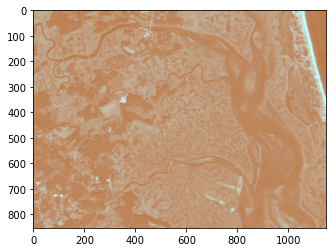

In [4]:
plt.imshow(marsh_images[7])

In [16]:
marsh_mask = cv.imread("marsh_mask.jpg")
gray_mask = cv.cvtColor(marsh_mask, cv.COLOR_BGR2GRAY)

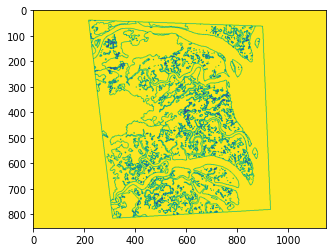

In [17]:
plt.imshow(gray_mask)

In [7]:
#marsh_images[7][:5,:5,]
marsh_images[7].shape

(853, 1149, 3)

In [19]:
#convert marsh mask to grayscale 

gray_mask

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

# Preliminary attempt 

Use many crops of the images/labels as training data for u-nets. Train to guess boundary or not boundary (at first). 

Issues to be solved: 

1. The solutions need to be stiched together somehow. 
2. The solution does not automatically output a curve - the boundary can be wider than 1.
3. The solution does not know what is marsh, water, etc. A solution to this might be to instead output three classes, then compare the boundary.
4. The mask only covers part of the image and has a weird shape. Also the parallelogram is included, which it shouldn't be. I think the right thing to do is to somehow mask off what's outside the parallelogram. 
5. Can't use any pre-trained u-net out of the box because of the extra image bands - need one with enough channels.


In [4]:
# get many crops as training data. 
#dtype=tf.float32

image = tf.convert_to_tensor(marsh_images, dtype =tf.int32)



Metal device set to: Apple M1


2022-01-12 22:41:08.188850: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-12 22:41:08.189069: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


(1, 853, 1149, 33)


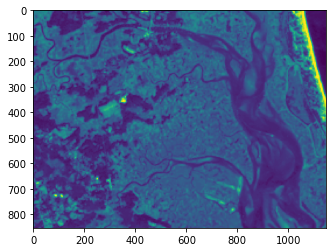

In [29]:
#reshape so there's 11*3 = 33 channels. 

reshaped_image = tf.transpose(image, perm=[1,2,0,3])
reshaped_image = tf.reshape(reshaped_image,[1,853,1149,33])
#check shape 
print(reshaped_image.shape)
plt.imshow(reshaped_image.numpy()[0,:,:,10])

In [9]:
# get patches. 

#earlier the kernel died - presumably I made it larger than the GPU memory. 
#Seems unlikely but maybe with the other stuff going on... 
#Shouldn't it not have issues like that? Oh well.

patches = tf.image.extract_patches(images=reshaped_image,
                           sizes=[1, 100, 100, 1],
                           strides=[1, 100, 100, 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')




In [8]:
  #testing out patches 
    
    n = 10
  # images is a 1 x 10 x 10 x 1 array that contains the numbers 1 through 100
  images = [[[[x * n + y + 1] for y in range(n)] for x in range(n)]]

  # We generate two outputs as follows:
  # 1. 3x3 patches with stride length 5
  # 2. Same as above, but the rate is increased to 2
  tf.image.extract_patches(images=images,
                           sizes=[1, 3, 3, 1],
                           strides=[1, 5, 5, 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')


<tf.Tensor: shape=(1, 2, 2, 9), dtype=int32, numpy=
array([[[[ 1,  2,  3, 11, 12, 13, 21, 22, 23],
         [ 6,  7,  8, 16, 17, 18, 26, 27, 28]],

        [[51, 52, 53, 61, 62, 63, 71, 72, 73],
         [56, 57, 58, 66, 67, 68, 76, 77, 78]]]], dtype=int32)>

(1, 8, 11, 100, 100, 33)


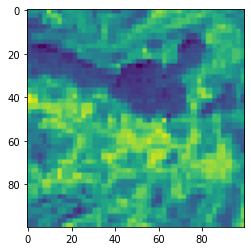

In [28]:
print(patches.shape)
#don't worry about the 1,8,11 for now - could be useful 
patches = tf.reshape(patches,[1,8,11,100,100,33])

plt.imshow(patches.numpy()[0,4,4,:,:,22])
#each entry is a flattened patch of shape 100x100

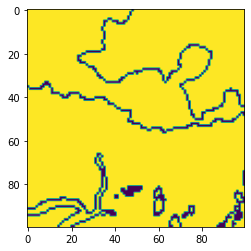

In [24]:
#if we did the same thing to the mask, we should get something matching.
mask_image = tf.convert_to_tensor(gray_mask, dtype =tf.int32)

reshaped_mask = tf.reshape(mask_image,[1,853,1149,1])

mask_patches = tf.image.extract_patches(images=reshaped_mask,
                           sizes=[1, 100, 100, 1],
                           strides=[1, 100, 100, 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')


mask_patches = tf.reshape(mask_patches,[1,8,11,100,100,1])

plt.imshow(mask_patches.numpy()[0,4,4,:,:,0])

#yay this works